In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


In [2]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [3]:
data_dir = '/media/rodsnjr/My Files/indoors/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

Below I'm running images through the VGG network in batches.

In [4]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 10
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)

    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            try:
                img = utils.load_image(os.path.join(class_path, file))
                batch.append(img.reshape((1, 224, 224, 3)))
                labels.append(each)
                
                # Running the batch through the network to get the codes
                if ii % batch_size == 0 or ii == len(files):
                    images = np.concatenate(batch)

                    feed_dict = {input_: images}
                    codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)

                    # Here I'm building an array of the codes
                    if codes is None:
                        codes = codes_batch
                    else:
                        codes = np.concatenate((codes, codes_batch))

                    # Reset to start building the next batch
                    batch = []
                    print('{} images processed'.format(ii))
            except Exception as e:
                print(e)
            
            

/home/rodsnjr/Git/indoor_recognition/udacity_transfer_learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting Doors images
10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
170 images processed
180 images processed
190 images processed
200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 images processed
380 images processed
390 images processed
400 images processe

200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 images processed
380 images processed
390 images processed
400 images processed
410 images processed
cannot reshape array of size 50176 into shape (1,224,224,3)
420 images processed
430 images processed
440 images processed
450 images processed
460 images processed
470 images processed
480 images processed
490 images processed
500 images processed
510 images processed
520 images processed
530 images processed
540 images processed
550 images processed
560 images processed
570 images processed
580 images processed
590 images processed
600 images processed
610 images processed
620 images processed
630 images processed
640 images proce

In [5]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

In [6]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

In [7]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)

labels_vecs = lb.transform(labels)

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

train_idx, val_idx = next(ss.split(codes, labels_vecs))

half_val_len = int(len(val_idx)/2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]

In [9]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (4376, 4096) (4376, 3)
Validation shapes (x, y): (547, 4096) (547, 3)
Test shapes (x, y): (548, 4096) (548, 3)


If you did it right, you should see these sizes for the training sets:

```
Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)
```

In [10]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

fc = tf.contrib.layers.fully_connected(inputs_, 256)
    
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [11]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

In [12]:
epochs = 10
iteration = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/flowers.ckpt")

Epoch: 1/10 Iteration: 0 Training loss: 4.30440
Epoch: 1/10 Iteration: 1 Training loss: 3.63409
Epoch: 1/10 Iteration: 2 Training loss: 2.59634
Epoch: 1/10 Iteration: 3 Training loss: 1.77715
Epoch: 1/10 Iteration: 4 Training loss: 1.19371
Epoch: 0/10 Iteration: 5 Validation Acc: 0.8775
Epoch: 1/10 Iteration: 5 Training loss: 1.58376
Epoch: 1/10 Iteration: 6 Training loss: 1.93192
Epoch: 1/10 Iteration: 7 Training loss: 1.62675
Epoch: 1/10 Iteration: 8 Training loss: 1.69475
Epoch: 1/10 Iteration: 9 Training loss: 1.41790
Epoch: 0/10 Iteration: 10 Validation Acc: 0.9232
Epoch: 2/10 Iteration: 10 Training loss: 0.81794
Epoch: 2/10 Iteration: 11 Training loss: 0.81261
Epoch: 2/10 Iteration: 12 Training loss: 0.61759
Epoch: 2/10 Iteration: 13 Training loss: 0.57325
Epoch: 2/10 Iteration: 14 Training loss: 0.64217
Epoch: 1/10 Iteration: 15 Validation Acc: 0.9250
Epoch: 2/10 Iteration: 15 Training loss: 0.40037
Epoch: 2/10 Iteration: 16 Training loss: 0.60541
Epoch: 2/10 Iteration: 17 Train

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [13]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt
Test accuracy: 0.9653


In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

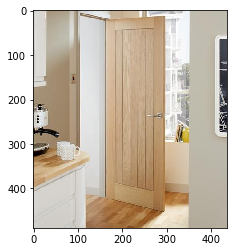

In [16]:
test_img_path = '/media/rodsnjr/My Files/indoors/Doors/0a1b2f3afbe729a0e1602e2d85703bb8.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [17]:
# Run this cell if you don't have a vgg graph built
with tf.Session() as sess:
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16.Vgg16()
    vgg.build(input_)

/home/rodsnjr/Git/indoor_recognition/udacity_transfer_learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s


In [18]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt


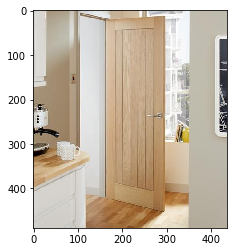

In [19]:
plt.imshow(test_img)

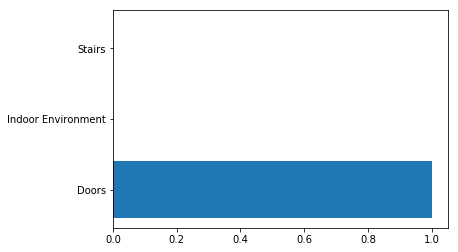

In [21]:
plt.barh(np.arange(3), prediction)
_ = plt.yticks(np.arange(3), lb.classes_)